In [1]:
import pandas as pd

# Load the provided CSV file to inspect its structure and content
file_path = 'China_edited_data.csv'
china_data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
china_data.head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,Observation Date
0,Anhui,Mainland China,1,0,0,32.0,117.0,22-01-2020
1,Anhui,Mainland China,9,0,0,32.0,117.0,23-01-2020
2,Anhui,Mainland China,15,0,0,32.0,117.0,24-01-2020
3,Anhui,Mainland China,39,0,0,32.0,117.0,25-01-2020
4,Anhui,Mainland China,60,0,0,32.0,117.0,26-01-2020


In [8]:
# Filter the data for Anhui
anhui_data = china_data[china_data['Province/State'] == 'Anhui']

# Sort by the observation date for time series consistency
anhui_data['Observation Date'] = pd.to_datetime(anhui_data['Observation Date'], dayfirst=True)
anhui_data = anhui_data.sort_values(by='Observation Date').reset_index(drop=True)
anhui_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_12108\1807593794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anhui_data['Observation Date'] = pd.to_datetime(anhui_data['Observation Date'], dayfirst=True)


,Province/State,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,Observation Date
0,Anhui,Mainland China,1,0,0,32.0,117.0,2020-01-22
1,Anhui,Mainland China,9,0,0,32.0,117.0,2020-01-23
2,Anhui,Mainland China,15,0,0,32.0,117.0,2020-01-24
3,Anhui,Mainland China,39,0,0,32.0,117.0,2020-01-25
4,Anhui,Mainland China,60,0,0,32.0,117.0,2020-01-26


In [9]:
# Define the initial susceptible population for Anhui (approx. 63 million)
total_population = 63_000

# Calculate the susceptible (S), asymptomatic (A), infected (I), recovered (R), and deceased (D) over time
# S = Total population - Confirmed cases at each time step (ignoring asymptomatic as it's not directly observed)
anhui_data['Susceptible'] = total_population/3

# Assume asymptomatic cases are zero initially (no direct observation)
anhui_data['Asymptomatic'] = anhui_data['Susceptible']/3

# Calculate infected cases as confirmed cases minus recovered and deaths
anhui_data['Infected'] = anhui_data['Confirmed'] - anhui_data['Recovered'] - anhui_data['Deaths']

# Extract recovered and deceased directly from the data
anhui_data['Recovered'] = anhui_data['Recovered']
anhui_data['Deceased'] = anhui_data['Deaths']

# Select only the necessary columns for the SAIRD model
saird_data = anhui_data[['Observation Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Deceased']]

# Show the first few rows of the processed data
saird_data.head()

,Observation Date,Susceptible,Asymptomatic,Infected,Recovered,Deceased
0,2020-01-22,21000.0,7000.0,1,0,0
1,2020-01-23,21000.0,7000.0,9,0,0
2,2020-01-24,21000.0,7000.0,15,0,0
3,2020-01-25,21000.0,7000.0,39,0,0
4,2020-01-26,21000.0,7000.0,60,0,0


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
# Assume we have time series data for S, A, I, R, and D, prepared as pandas DataFrame (as saird_data).
# Convert data to tensors
time_series = torch.tensor(pd.to_datetime(saird_data['Observation Date']).view(int) / 1e18, dtype=torch.float32, requires_grad=True).view(-1, 1)
susceptible = torch.tensor(saird_data['Susceptible'].values, dtype=torch.float32).view(-1, 1)
asymptomatic = torch.tensor(saird_data['Asymptomatic'].values, dtype=torch.float32).view(-1, 1)
infected = torch.tensor(saird_data['Infected'].values, dtype=torch.float32).view(-1, 1)
recovered = torch.tensor(saird_data['Recovered'].values, dtype=torch.float32).view(-1, 1)
deceased = torch.tensor(saird_data['Deceased'].values, dtype=torch.float32).view(-1, 1)

# Step 2: Neural Network Definition
class SAIRD_PINN(nn.Module):
    def __init__(self, layers):
        super(SAIRD_PINN, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(layers) - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.model.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, t):
        return self.model(t)

# Define the layers: 1 input (time) and 5 outputs (S, A, I, R, D)
layers = [1, 64, 64, 64, 5]
pinn = SAIRD_PINN(layers)

# Step 3: Define Loss Functions and Physics Constraints
# Constants for the model
beta_1 = torch.tensor(0.1, requires_grad=True)
beta_2 = torch.tensor(0.1, requires_grad=True)
gamma_1 = torch.tensor(0.1, requires_grad=True)
gamma_2 = torch.tensor(0.1, requires_grad=True)
gamma_3 = torch.tensor(0.1, requires_grad=True)
kappa_1 = torch.tensor(0.1, requires_grad=True)
kappa_2 = torch.tensor(0.1, requires_grad=True)
mu = torch.tensor(0.01, requires_grad=True)
Lambda = torch.tensor(0.0)  # Assume no population inflow for simplicity

# Loss function for data fitting
def data_loss(pred, true):
    return 1/total_population**2 * torch.mean((pred - true) ** 2)

# Physics-informed loss function
def physics_loss(time, S, A, I, R, D):
    dS_dt = torch.autograd.grad(S, time, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dA_dt = torch.autograd.grad(A, time, grad_outputs=torch.ones_like(A), create_graph=True)[0]
    dI_dt = torch.autograd.grad(I, time, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dR_dt = torch.autograd.grad(R, time, grad_outputs=torch.ones_like(R), create_graph=True)[0]
    dD_dt = torch.autograd.grad(D, time, grad_outputs=torch.ones_like(D), create_graph=True)[0]

    eq1 = dS_dt - (Lambda - beta_1 * S * A - beta_2 * S * I - mu * S)
    eq2 = dA_dt - (beta_1 * S * A - (gamma_1 + gamma_2 + gamma_3) * A - mu * A)
    eq3 = dI_dt - (beta_2 * S * I + gamma_1 * A - (kappa_1 + kappa_2) * I - mu * I)
    eq4 = dR_dt - (gamma_2 * A + kappa_1 * I - mu * R)
    eq5 = dD_dt - (gamma_3 * A + kappa_2 * I)

    return torch.mean(eq1**2) + torch.mean(eq2**2) + torch.mean(eq3**2) + torch.mean(eq4**2) + torch.mean(eq5**2)

# Step 4: Training the Model
# Define optimizer
optimizer = torch.optim.Adam(list(pinn.parameters()) + [beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu], lr=1e-4)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass through the model
    saird_pred = pinn(time_series)
    S_pred, A_pred, I_pred, R_pred, D_pred = saird_pred[:, 0], saird_pred[:, 1], saird_pred[:, 2], saird_pred[:, 3], saird_pred[:, 4]

    # Compute losses
    loss_data = data_loss(S_pred, susceptible) + data_loss(A_pred, asymptomatic) + data_loss(I_pred, infected) + data_loss(R_pred, recovered) + data_loss(D_pred, deceased)
    loss_physics = physics_loss(time_series, S_pred, A_pred, I_pred, R_pred, D_pred)
    total_loss = loss_data + loss_physics

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss.item()}, Data Loss: {loss_data.item()}, Physics Loss: {loss_physics.item()}')

# Save the trained model
torch.save(pinn.state_dict(), 'saird_pinn_model.pt')
# After training the model, you can access the estimated parameters like this:
print("Estimated Parameters:")
print(f"Beta_1 (Transmission rate from asymptomatic): {beta_1.item()}")
print(f"Beta_2 (Transmission rate from infected): {beta_2.item()}")
print(f"Gamma_1 (Rate of asymptomatic becoming infected): {gamma_1.item()}")
print(f"Gamma_2 (Recovery rate of asymptomatic): {gamma_2.item()}")
print(f"Gamma_3 (Death rate of asymptomatic): {gamma_3.item()}")
print(f"Kappa_1 (Recovery rate of infected): {kappa_1.item()}")
print(f"Kappa_2 (Death rate of infected): {kappa_2.item()}")
print(f"Mu (Natural death rate): {mu.item()}")
print(f"Mu (Natural death rate): {Lambda.item()}")

C:\Users\user\AppData\Local\Temp\ipykernel_12108\3441138249.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  time_series = torch.tensor(pd.to_datetime(saird_data['Observation Date']).view(int) / 1e18, dtype=torch.float32, requires_grad=True).view(-1, 1)


Epoch 0, Total Loss: 0.13986515998840332, Data Loss: 0.12359008193016052, Physics Loss: 0.016275085508823395
Epoch 1000, Total Loss: 0.12358857691287994, Data Loss: 0.12358856946229935, Physics Loss: 9.264656597451904e-09
Epoch 2000, Total Loss: 0.12358749657869339, Data Loss: 0.12358748912811279, Physics Loss: 9.727414429505643e-09
Epoch 3000, Total Loss: 0.12358547002077103, Data Loss: 0.12358546257019043, Physics Loss: 1.1009284150986787e-08
Epoch 4000, Total Loss: 0.1235819086432457, Data Loss: 0.1235818937420845, Physics Loss: 1.4672755455080733e-08
Epoch 5000, Total Loss: 0.12357456982135773, Data Loss: 0.12357454001903534, Physics Loss: 2.698213563689933e-08
Epoch 6000, Total Loss: 0.12355978786945343, Data Loss: 0.12355973571538925, Physics Loss: 5.384582735246113e-08
Epoch 7000, Total Loss: 0.12353777885437012, Data Loss: 0.12353770434856415, Physics Loss: 7.54493214571994e-08
Epoch 8000, Total Loss: 0.12351064383983612, Data Loss: 0.12351056933403015, Physics Loss: 7.62468914

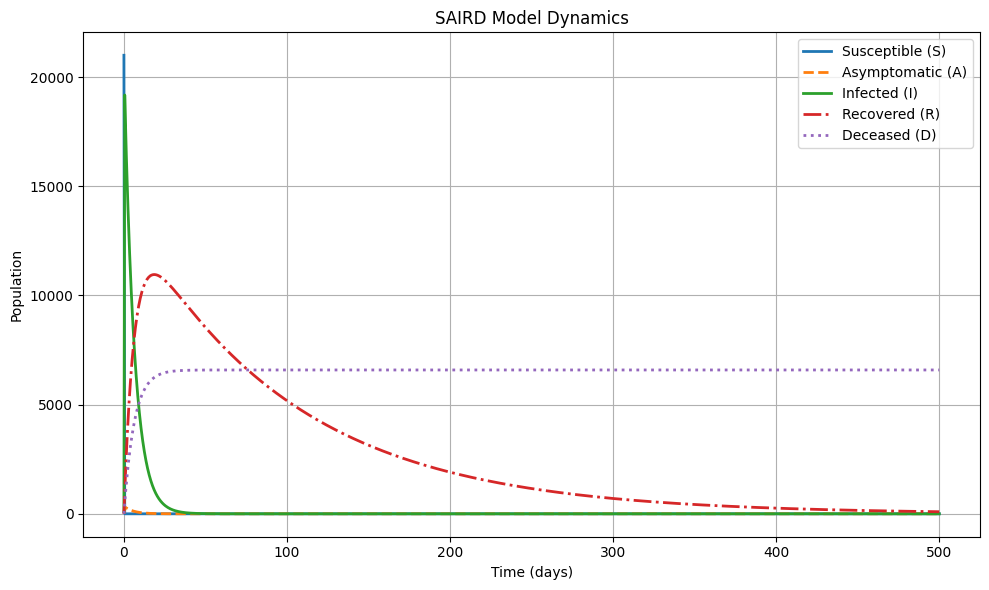

In [20]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the SAIRD model equations
def saird_model(y, t, beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu, Lambda):
    S, A, I, R, D = y

    dS_dt = Lambda - beta_1 * S * A - beta_2 * S * I - mu * S
    dA_dt = beta_1 * S * A - (gamma_1 + gamma_2 + gamma_3) * A - mu * A
    dI_dt = beta_2 * S * I + gamma_1 * A - (kappa_1 + kappa_2) * I - mu * I
    dR_dt = gamma_2 * A + kappa_1 * I - mu * R
    dD_dt = gamma_3 * A + kappa_2 * I
    
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Initial conditions and parameters
S0 = 63_000/3  # Initial susceptible population (approximation for Anhui)
I0 = 100  # Assume a third are infected initially
A0 = 10  # Assume a third of the infected are asymptomatic
R0 = 0  # Initial recovered
D0 = 0  # Initial deaths

# Parameters (initial guesses)
beta_1 = 0.2  # Transmission rate from asymptomatic individuals
beta_2 = 0.3  # Transmission rate from infected individuals
gamma_1 = 0.1  # Rate of asymptomatic becoming infected
gamma_2 = 0.05  # Recovery rate of asymptomatic individuals
gamma_3 = 0.02  # Death rate of asymptomatic individuals
kappa_1 = 0.1  # Recovery rate of infected individuals
kappa_2 = 0.05  # Death rate of infected individuals
mu = 0.01  # Natural death rate
Lambda = 0  # Assume no population inflow

# Time points (in days)
t = np.linspace(0, 500, 1000)  # Simulate for 100 days

# Solve the ODE
y0 = [S0, A0, I0, R0, D0]
solution = odeint(saird_model, y0, t, args=(beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu, Lambda))
S, A, I, R, D = solution.T

# Plot the SAIRD model solution
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible (S)', linewidth=2)
plt.plot(t, A, label='Asymptomatic (A)', linestyle='--', linewidth=2)
plt.plot(t, I, label='Infected (I)', linewidth=2)
plt.plot(t, R, label='Recovered (R)', linestyle='-.', linewidth=2)
plt.plot(t, D, label='Deceased (D)', linestyle=':', linewidth=2)

# Format the plot
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SAIRD Model Dynamics')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

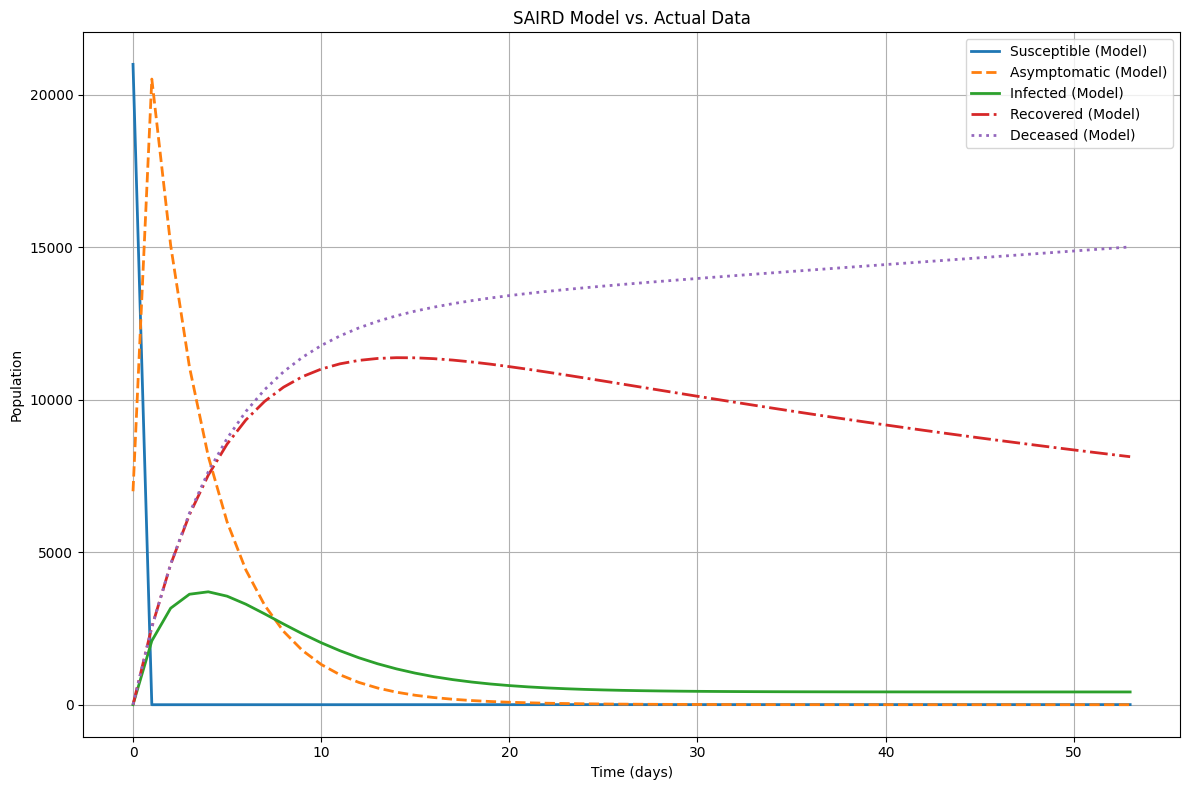

In [24]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Load the provided dataset (adjust the file path if needed)
# Assuming 'Observation Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Deceased'
# data = pd.read_csv('path_to_your_provided_data.csv')
# data['Observation Date'] = pd.to_datetime(data['Observation Date'])
# data = data.sort_values('Observation Date')

# Extract time series data for each compartment
time_series = (anhui_data['Observation Date'] - anhui_data['Observation Date'].iloc[0]).dt.days.values
susceptible_data = anhui_data['Susceptible'].values
asymptomatic_data = anhui_data['Asymptomatic'].values
infected_data = anhui_data['Infected'].values
recovered_data = anhui_data['Recovered'].values
deceased_data = anhui_data['Deceased'].values

# Initial conditions from the first row of the dataset
S0 = susceptible_data[0]
A0 = asymptomatic_data[0]
I0 = infected_data[0]
R0 = recovered_data[0]
D0 = deceased_data[0]

# Parameters (initial guesses, can be tuned)
# beta_1 = 0.2  # Transmission rate from asymptomatic individuals
# beta_2 = 0.3  # Transmission rate from infected individuals
# gamma_1 = 0.1  # Rate of asymptomatic becoming infected
# gamma_2 = 0.05  # Recovery rate of asymptomatic individuals
# gamma_3 = 0.02  # Death rate of asymptomatic individuals
# kappa_1 = 0.1  # Recovery rate of infected individuals
# kappa_2 = 0.05  # Death rate of infected individuals
# mu = 0.01  # Natural death rate
# Lambda = 0  # Assume no population inflow

beta_1 = 0.025436125695705414
beta_2 = 0.06927885860204697
gamma_1 = 0.09538008272647858
gamma_2 = 0.10121732950210571
gamma_3 = 0.10084612667560577
kappa_1 = 0.11776547878980637
kappa_2 = 0.1062522605061531
mu = 0.014994528144598007
Lambda = 100

# Define the SAIRD model equations
def saird_model(y, t, beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu, Lambda):
    S, A, I, R, D = y

    dS_dt = Lambda - beta_1 * S * A - beta_2 * S * I - mu * S
    dA_dt = beta_1 * S * A - (gamma_1 + gamma_2 + gamma_3) * A - mu * A
    dI_dt = beta_2 * S * I + gamma_1 * A - (kappa_1 + kappa_2) * I - mu * I
    dR_dt = gamma_2 * A + kappa_1 * I - mu * R
    dD_dt = gamma_3 * A + kappa_2 * I
    
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Time points (in days)
t = time_series

# Solve the ODE using initial conditions from data
y0 = [S0, A0, I0, R0, D0]
solution = odeint(saird_model, y0, t, args=(beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu, Lambda))
S, A, I, R, D = solution.T

# Plot the SAIRD model solution against actual data
plt.figure(figsize=(12, 8))
plt.plot(t, S, label='Susceptible (Model)', linewidth=2)
plt.plot(t, A, label='Asymptomatic (Model)', linestyle='--', linewidth=2)
plt.plot(t, I, label='Infected (Model)', linewidth=2)
plt.plot(t, R, label='Recovered (Model)', linestyle='-.', linewidth=2)
plt.plot(t, D, label='Deceased (Model)', linestyle=':', linewidth=2)

# Plot the actual data points
# plt.scatter(t, susceptible_data, label='Susceptible (Data)', color='blue', s=10)
# plt.scatter(t, asymptomatic_data, label='Asymptomatic (Data)', color='orange', s=10)
# plt.scatter(t, infected_data, label='Infected (Data)', color='red', s=10)
# plt.scatter(t, recovered_data, label='Recovered (Data)', color='green', s=10)
# plt.scatter(t, deceased_data, label='Deceased (Data)', color='black', s=10)

# Format the plot
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SAIRD Model vs. Actual Data')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### USING COVSIRPHY

In [23]:
import covsirphy as cs

eng = cs.DataEngineer()
eng.download(country=None, databases=["japan", "covid19dh"]);

eng.clean()
eng.transform()
actual_df, status, _ = eng.subset(geo=("China",), variables="SIRF", complement=True)
print(status)
actual_df.tail()



monotonic increasing complemented confirmed data and 
monotonic increasing complemented fatal data and 
fully complemented recovered data


,Susceptible,Infected,Recovered,Fatal
Date,,,,
2023-12-15,1293408363.0,865,99198892,121880
2023-12-16,1293408363.0,851,99198906,121880
2023-12-17,1293408363.0,838,99198919,121880
2023-12-18,1293408363.0,825,99198932,121880
2023-12-19,1293408363.0,825,99198932,121880


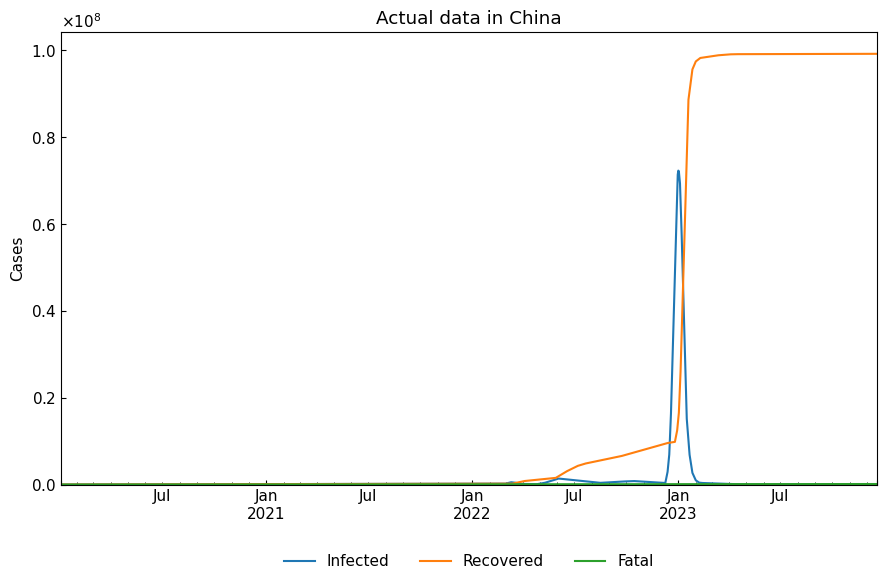

In [16]:
cs.line_plot(actual_df.drop("Susceptible", axis=1), "Actual data in China")

In [18]:
dyn_act = cs.Dynamics.from_data(model=cs.SIRFModel, data=actual_df, name="China")
# Show registered values
dyn_act.register().tail()

,Susceptible,Infected,Recovered,Fatal,theta,kappa,rho,sigma
Date,,,,,,,,
2023-12-15,1293408363.0,865.0,99198892.0,121880.0,<NA>,<NA>,<NA>,<NA>
2023-12-16,1293408363.0,851.0,99198906.0,121880.0,<NA>,<NA>,<NA>,<NA>
2023-12-17,1293408363.0,838.0,99198919.0,121880.0,<NA>,<NA>,<NA>,<NA>
2023-12-18,1293408363.0,825.0,99198932.0,121880.0,<NA>,<NA>,<NA>,<NA>
2023-12-19,1293408363.0,825.0,99198932.0,121880.0,<NA>,<NA>,<NA>,<NA>


In [19]:
dyn_act.summary()

,Start,End
Phase,,
0th,2020-01-03,2023-12-19


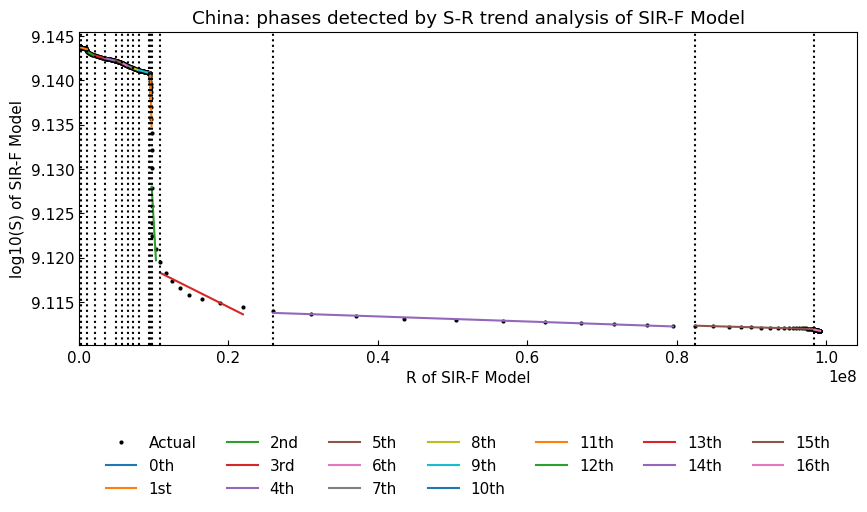

Phase,0th,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th
Start,2020-01-03,2022-03-14,2022-05-17,2022-06-06,2022-06-24,2022-07-23,2022-08-26,2022-09-20,2022-10-08,2022-10-26,2022-12-06,2022-12-13,2022-12-21,2022-12-28,2023-01-05,2023-01-16,2023-02-18
End,2022-03-13,2022-05-16,2022-06-05,2022-06-23,2022-07-22,2022-08-25,2022-09-19,2022-10-07,2022-10-25,2022-12-05,2022-12-12,2022-12-20,2022-12-27,2023-01-04,2023-01-15,2023-02-17,2023-12-19


In [20]:
dyn_act.segment();
# Show summary
dyn_act.summary().T

In [60]:
dyn_act.estimate()
print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")
# Show summary
dyn_act.summary()

100%|██████████| 17/17 [00:25<00:00,  1.53s/it]


Tau value [min]: 288


ZeroDivisionError: Kappa, rho and sigma must be over 0 to calculate dimensional parameters with SIR-F Model.

In [21]:
est_df = dyn_act.estimate_params()
# Show RMSLE scores pf phases
est_df = est_df.drop_duplicates()
est_df.index.name = "Start"
display(est_df)

  0%|          | 0/17 [00:04<?, ?it/s]


KeyError: 'A'